## 3 线性神经网络

### 3.1 线性回归

问题定义：

$$
\hat{y} = \mathbf{w}^\top \mathbf{x} + b
$$

损失函数：

$$
l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2
$$

$$
\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b)
$$

解析解：

$$
\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}
$$



本书中我们用到一种名为梯度下降（gradient descent）的方法， 这种方法几乎可以优化所有深度学习模型。 它通过不断地在损失函数递减的方向上更新参数来降低误差。

梯度下降最简单的用法是计算损失函数（数据集中所有样本的损失均值）关于模型参数的导数（在这里也可以称为梯度）。但实际中的执行可能会非常慢：因为在每一次更新参数之前，我们必须遍历整个数据集。 因此，我们通常会在每次需要计算更新的时候随机抽取一小批样本， 这种变体叫做小批量随机梯度下降（minibatch stochastic gradient descent）。

在每次迭代中，我们首先随机抽样一个小批量$\Beta$， 它是由固定数量的训练样本组成的。 然后，我们计算小批量的平均损失关于模型参数的导数（也可以称为梯度）。 最后，我们将梯度乘以一个预先确定的正数 $\eta$，并从当前参数的值中减掉。

$$
(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b)
$$

总结一下，算法的步骤如下：

1. 初始化模型参数的值，如随机初始化； 
2. 从数据集中随机抽取小批量样本且在负梯度的方向上更新参数，并不断迭代这一步骤。 

对于平方损失和仿射变换，我们可以明确地写成如下形式:

$$
\begin{split}\begin{aligned} \mathbf{w} &\leftarrow \mathbf{w} -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right),\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_b l^{(i)}(\mathbf{w}, b)  = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \end{aligned}\end{split}
$$


#### 3.1.2 矢量化加速

在训练我们的模型时，我们经常希望能够同时处理整个小批量的样本。为了实现这一点，需要我们对计算进行矢量化， 从而利用线性代数库，而不是在Python中编写开销高昂的for循环。


In [2]:
%matplotlib inline
import math
import time
import numpy as np
import torch

In [3]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [4]:
# 定义一个计时器
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [7]:
# 测试for循环
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
print(f'{timer.stop():.5f} sec')

0.09545 sec


In [8]:
# 矩阵重载符号+
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00059 sec'

#### 3.1.3 正态分布与平方损失

接下来，我们通过对噪声分布的假设来解读平方损失目标函数。

正态分布公式：

$$
p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right)
$$

In [9]:
#定义一个函数计算正态分布
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

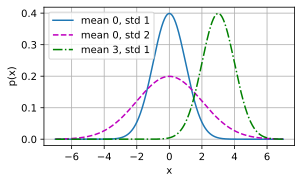

In [10]:
# 再次使用numpy进行可视化
import utils
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
utils.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

均方误差损失函数假设的公式：

$$
y = \mathbf{w}^\top \mathbf{x} + b + \epsilon, \epsilon \sim \mathcal{N}(0, \sigma^2)
$$

因此，我们现在可以写出通过给定的$\mathbf{x}$观测到特定$y$的似然（likelihood）：

$$
P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).
$$

现在，根据极大似然估计法，参数$\mathbf{w}$和$b$的最优值是使整个数据集的似然最大的值：

$$
P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)}|\mathbf{x}^{(i)}).
$$

根据极大似然估计法选择的估计量称为极大似然估计量。 虽然使许多指数函数的乘积最大化看起来很困难， 但是我们可以在不改变目标的前提下，通过最大化似然对数来简化。 由于历史原因，优化通常是说最小化而不是最大化。 我们可以改为最小化负对数似然$-\log P(\mathbf y \mid \mathbf X)$。 由此可以得到的数学公式是：

$$
-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.
$$

In [11]:
### 3.2 线性回归的从零开始实现

In [12]:
%matplotlib inline
import random
import torch

#### 3.2.1 生成数据集

In [14]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.1190, -0.9996]) 
label: tensor([7.3445])


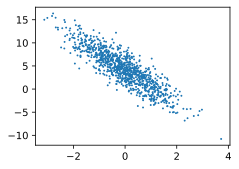

In [15]:
utils.set_figsize()
utils.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 3.2 线性回归的从零开始实现

In [7]:
%matplotlib inline
import random
import torch
import utils

#### 3.2.1 生成数据集

我们使用线性模型参数 $\mathbf{w} = [2, -3.4]^\top$ , $b = 4.2$ 和噪声项 $\epsilon$

$$
\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.
$$

标准差为0.01

In [3]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [6]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([0.9420, 0.9915]) 
label: tensor([2.7164])


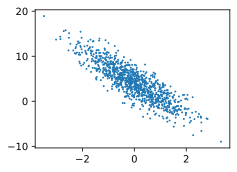

In [8]:
utils.set_figsize()
utils.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

#### 3.2.2 读取数据集

打乱数据集中的样本并以小批量方式获取数据

In [9]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [16]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.5553, -2.1357],
        [-0.2423, -1.4864],
        [ 0.1771,  0.2672],
        [ 0.7273,  2.8224],
        [-0.7163,  1.6975],
        [-0.2717,  2.1431],
        [-0.5005, -0.6292],
        [ 0.5654,  0.1722],
        [ 2.0271,  0.7024],
        [-1.2262, -0.2638]]) 
 tensor([[10.3480],
        [ 8.7817],
        [ 3.6326],
        [-3.9193],
        [-2.9998],
        [-3.6138],
        [ 5.3523],
        [ 4.7357],
        [ 5.8726],
        [ 2.6506]])


#### 3.2.3 初始化模型参数

从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0

In [17]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

#### 3.2.4 定义模型

In [18]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

#### 3.2.5 定义损失函数

In [19]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

#### 3.2.6 定义优化算法

小批量随机梯度下降

In [20]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

#### 3.2.7 训练

现在我们已经准备好了模型训练所有需要的要素，可以实现主要的训练过程部分了。 理解这段代码至关重要，因为从事深度学习后， 相同的训练过程几乎一遍又一遍地出现。 在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。 计算完损失后，我们开始反向传播，存储每个参数的梯度。 最后，我们调用优化算法sgd来更新模型参数。

概括一下，我们将执行以下循环：

- 初始化参数
- 重复以下训练，直到完成
  - 计算梯度 $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
  - 更新参数 $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

在每个迭代周期（epoch）中，我们使用data_iter函数遍历整个数据集， 并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。 这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设为3和0.03。 设置超参数很棘手，需要通过反复试验进行调整。 我们现在忽略这些细节，以后会在 11节中详细介绍。

In [21]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.034788
epoch 2, loss 0.000129
epoch 3, loss 0.000052


In [22]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0001, -0.0008], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0014], grad_fn=<RsubBackward1>)


### 3.3 线性回归的简洁实现

In [4]:
# 生成数据集

import numpy as np
import torch
from torch.utils import data
import utils

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [5]:
# 读取数据集

def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [6]:
# 取数据

next(iter(data_iter))

[tensor([[-0.0719,  0.7608],
         [-1.1341,  2.2916],
         [-2.0957,  2.3810],
         [ 0.6015, -0.4906],
         [ 0.0673, -0.9638],
         [-0.8743, -1.4724],
         [ 0.4440, -1.7671],
         [ 0.1213,  1.5611],
         [-0.2621, -1.4135],
         [-0.4134,  1.8281]]),
 tensor([[ 1.4872],
         [-5.8366],
         [-8.0950],
         [ 7.0759],
         [ 7.6262],
         [ 7.4638],
         [11.0976],
         [-0.8763],
         [ 8.4803],
         [-2.8296]])]

In [7]:

# 定义模型

# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [8]:
# 初始化模型参数
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [9]:
# 定义损失函数
loss = nn.MSELoss()

In [10]:
# 定义优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [11]:
# 训练
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000189
epoch 2, loss 0.000106
epoch 3, loss 0.000108


In [12]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-0.0001,  0.0016])
b的估计误差： tensor([-0.0006])


### 3.4 softmax回归

分类问题

$\{\text{狗}, \text{猫}, \text{鸡}\}$ 类似的分类问题

#### 3.4.2 网络架构

为了估计所有可能类别的条件概率，我们需要一个有多个输出的模型，每个类别对应一个输出。 为了解决线性模型的分类问题，我们需要和输出一样多的仿射函数（affine function）。 每个输出对应于它自己的仿射函数。 在我们的例子中，由于我们有4个特征和3个可能的输出类别， 我们将需要12个标量来表示权重（带下标的）$w$ ， 3个标量来表示偏置（带下标的）。 下面我们为每个输入计算三个未规范化的预测（logit）： $o_1$ 、 $o_2$ 和 $o_3$。

$$
\begin{split}\begin{aligned}
o_1 &= x_1 w_{11} + x_2 w_{12} + x_3 w_{13} + x_4 w_{14} + b_1,\\
o_2 &= x_1 w_{21} + x_2 w_{22} + x_3 w_{23} + x_4 w_{24} + b_2,\\
o_3 &= x_1 w_{31} + x_2 w_{32} + x_3 w_{33} + x_4 w_{34} + b_3.
\end{aligned}\end{split}
$$

![softmax](img/softmax.png)

通过向量形式表达为

$$
\mathbf{o} = \mathbf{W} \mathbf{x} + \mathbf{b}
$$

#### 3.4.3 全连接层的参数开销

全连接层是“完全”连接的，可能有很多可学习的参数。对于任何具有 $d$ 个输入和 $q$ 个输出的全连接层， 参数开销为 $\mathcal{O}(dq)$ 。可以减少到 $\mathcal{O}(\frac{dq}{n})$ ， 其中超参数 $n$ 可以由我们灵活指定，以在实际应用中平衡参数节约和模型有效性


#### 3.4.4 softmax运算

softmax函数

$$
\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o})\quad \text{其中}\quad \hat{y}_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}
$$

这里，对于所有 $j$ 的总有 $0 \leq \hat{y}_j \leq 1$ 。因此，$\hat{\mathbf{y}}$ 可以视为一个正确的概率分布。 softmax运算不会改变未规范化的预测 $\mathbf{o}$ 之间的大小次序，只会确定分配给每个类别的概率。 因此，在预测过程中，我们仍然可以用下式来选择最有可能的类别。

$$
\operatorname*{argmax}_j \hat y_j = \operatorname*{argmax}_j o_j.
$$

尽管softmax是一个非线性函数，但softmax回归的输出仍然由输入特征的仿射变换决定。 因此，softmax回归是一个线性模型（linear model）。

#### 3.4.5 小批量样本的矢量化

$$
\begin{split}\begin{aligned} \mathbf{O} &= \mathbf{X} \mathbf{W} + \mathbf{b}, \\ \hat{\mathbf{Y}} & = \mathrm{softmax}(\mathbf{O}). \end{aligned}\end{split}
$$


#### 3.4.6 损失函数

对数似然

#### 3.4.7 信息论基础

熵

$$
H[P] = \sum_j - P(j) \log P(j).
$$




## 3.5 图像分类数据集

In [2]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import utils

utils.use_svg_display()

#### 3.5.1 读取数据

使用Fashion-MNIST数据集


In [4]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=trans, download=True)

100%|██████████| 26421880/26421880 [00:17<00:00, 1506428.41it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 135620.59it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:08<00:00, 526129.11it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5620061.68it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
